CE 로 학습한 실험 코드 (wandb run ID)

| | NoisyCIFAR10 | NoisyCIFAR100 |
|---|---|---|
| symm-20% | 3yg20n8g | db6cpa4w |
| symm-50% | 2cvre1ep | 6ud3a42m |
| symm-80% | h6hbbj3p | l4uscm5j |


각 실험별로 `model_9.pth`, `model_19.pth`, ..., `model_199.pth` 체크포인트를 저장해 놨음.

In [21]:

import argparse
import os
import torch
import numpy as np
import yaml
from trainer import Trainer
import wandb


@torch.no_grad()
def calculate_accuracy(pred: torch.Tensor, target: torch.Tensor, k=1):
    """Computes top-k accuracy"""
    k = min(k, pred.size(-1)) # in case num_classes is smaller than k.
    pred = torch.topk(pred, k, -1).indices
    correct = pred.eq(target[..., None].expand_as(pred)).any(dim=-1)
    accuracy = correct.float().mean().mul(100.0)
    return accuracy


torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
torch.set_float32_matmul_precision('highest')

device = torch.device("cuda:0")


# config = yaml.safe_load(
# r"""
# data:
#     dataset: old_noisy_cifar10
#     noise_type: symmetric
#     noise_rate: 0.2
#     random_seed: 925

# model:
#     architecture: resnet34
#     num_classes: 10

# trainer:
#     num_workers: 4
#     batch_size: 128
# """
# )


## Load config
wandb_run_id = "3yg20n8g"
config = yaml.safe_load(open(wandb.restore('config.yaml', run_path=f"hyounguk-shon/noisy-label/{wandb_run_id}", replace=True, root='./temp').name, "r"))


## Load model
import models
model = models.get_model(**config["model"]["value"])

ckpt_name="model_199.pth"
checkpoint = wandb.restore(ckpt_name, run_path=f"hyounguk-shon/noisy-label/{wandb_run_id}", replace=True, root='./temp')
model.load_state_dict(torch.load(checkpoint.name, map_location="cpu"))
print(f"Loaded checkpoint: {checkpoint.name}")

trainer = Trainer(
    model=model,
    config=config['trainer']["value"],
    device=device,
)

Loaded checkpoint: ./temp/model_199.pth


In [36]:
## Load dataset
import datasets

train_dataset, test_dataset = datasets.get_dataset(**config["data"]["value"])

dataset = train_dataset

is_noisy = dataset.targets != dataset.targets_gt

print(dataset)

Files already downloaded and verified
True noise rate: 0.1806
Files already downloaded and verified
Dataset OldNoisyCIFAR10
    Number of datapoints: 50000
    Root location: /dev/shm/data/
    Split: Train


In [37]:
## Run inference
dataset.transform = datasets.get_transform('none', dataset) # no augmentation

results = trainer.inference(dataset)
results

{'logits': tensor([[ 1.4694, -4.4222, -3.1109,  ...,  0.5835,  0.2645, -0.2806],
         [-6.7535, -0.1942, -6.5951,  ...,  0.1252, -3.4341,  1.2358],
         [-3.8192, -6.0159,  1.0770,  ..., -4.1146, -0.3491, 16.9762],
         ...,
         [-2.4937, -1.0047,  2.3382,  ...,  0.5694, -0.8984, 17.1006],
         [-3.0242, 10.1192, -4.9183,  ..., -1.8843, -4.8029, -3.9869],
         [ 0.0414, 14.8339,  3.8436,  ..., -0.9664, -3.9662, -3.9695]]),
 'target': tensor([6, 3, 9,  ..., 9, 6, 1]),
 'target_gt': tensor([6, 9, 9,  ..., 9, 1, 1])}

In [38]:
calculate_accuracy(results['logits'][is_noisy], results['target_gt'][is_noisy], k=1)

tensor(0.0111)

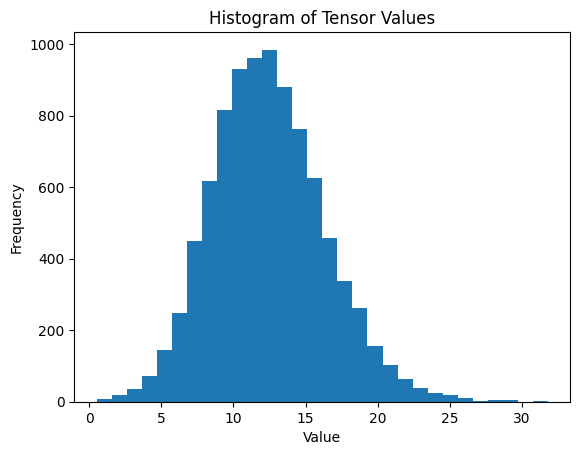

In [39]:
noaug_losses = torch.nn.functional.cross_entropy(results['logits'][is_noisy], results['target_gt'][is_noisy], reduction='none')

import torch
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(noaug_losses.numpy(), bins=30)  # You can adjust the number of bins
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [40]:
## Run multiple inferences to aggregate results over random augmentations

from collections import defaultdict
import tqdm

dataset.transform = datasets.get_transform('autoaugment', dataset)

n_repeat = 20

total_results = defaultdict(list)
for _ in tqdm.trange(n_repeat):
    results = trainer.inference(dataset)
    for k, v in results.items():
        total_results[k].append(v)
total_results = {k: torch.stack(v, dim=1) for k, v in total_results.items()} # shape is (n_samples, n_repeat, ...)
total_results

100%|██████████| 20/20 [02:26<00:00,  7.34s/it]


{'logits': tensor([[[-2.0579e+00, -3.9554e+00,  1.3010e+00,  ...,  1.7167e+00,
            3.4257e-01, -5.4743e-01],
          [-2.4120e+00, -1.2863e+00, -1.0443e+00,  ...,  1.5286e+00,
            6.0443e+00, -1.0738e+00],
          [-3.2267e+00, -2.4885e+00, -3.9699e+00,  ..., -3.4423e+00,
            4.7416e+00, -2.0786e+00],
          ...,
          [-4.7886e+00, -1.4294e+00,  2.5175e-01,  ...,  8.1002e-01,
            3.8338e+00,  4.6998e+00],
          [ 1.7999e+00, -4.2265e+00, -3.0706e+00,  ..., -7.3952e-02,
            3.2115e-01, -1.3218e+00],
          [-4.7886e+00, -1.4294e+00,  2.5175e-01,  ...,  8.1002e-01,
            3.8338e+00,  4.6998e+00]],
 
         [[-7.1509e+00,  5.9506e+00, -4.4304e+00,  ...,  3.2141e-01,
           -3.9090e+00,  1.1959e+01],
          [-6.8247e+00, -1.2923e-01, -6.6182e+00,  ...,  2.0146e-01,
           -3.3141e+00,  1.5623e+00],
          [ 2.9074e+00,  3.4582e-01, -4.2285e+00,  ...,  2.3712e+00,
           -3.1888e+00,  7.9862e+00],
         

In [41]:
calculate_accuracy(total_results['logits'][is_noisy].mean(1), total_results['target_gt'][is_noisy][:,0], k=1)

tensor(11.3043)

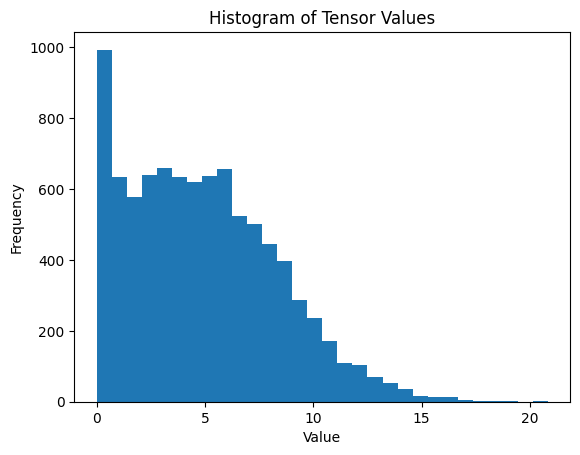

In [43]:
aug_losses = torch.nn.functional.cross_entropy(total_results['logits'][is_noisy].mean(1), total_results['target_gt'][is_noisy][:,0], reduction='none')

import torch
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist(aug_losses.numpy(), bins=30)  # You can adjust the number of bins
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


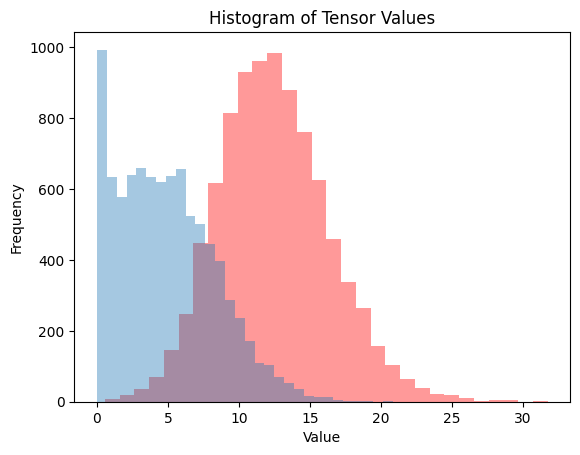

In [45]:
import torch
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(noaug_losses, bins=30, color='red', alpha=0.4)  # You can adjust the number of bins
# Plotting the histogram
plt.hist(aug_losses, bins=30, alpha=0.4)  # You can adjust the number of bins
plt.title("Histogram of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
